In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

system_name = 'ant_cons2'
run_name = '4p_acet_1'
data_dir = 'data/' + system_name + '/' + run_name + '/'

### Importing the paramters

In [2]:
env_params = ut.read_params(data_dir+'param_env.txt')
for ep in env_params:
    print(ep, env_params[ep])
alg_params = ut.read_params(data_dir+'param_alg.txt')
for ep in alg_params:
    print(ep, alg_params[ep])

max_k 10.0
n_recipients 3.0
p_succ 0.1
p_consume 0.05
init_k [3. 3. 3. 3.]
alg_type ac_et
gamma 0.999
stop_by_discount false
lambda_actor 0.999
lambda_critic 0.999
n_steps 50000000.0
traj_points 500.0
eval_steps 1000.0
a0 0.0005
ac 100000.0
a_expn 0.75
a_burn 16666666.666666666
b0 0.00025
bc 100000.0
b_expn 0.8
b_burn 25000000.0
a_player_factor [0.33333333 1.         1.         1.        ]
b_player_factor [0.33333333 1.         1.         1.        ]
init_values 10.0


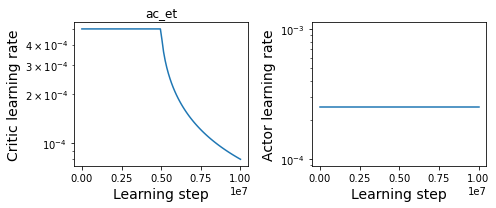

In [4]:
fig, (ax1, ax2) = ut.plot_lr(alg_params)
ax1.set_title(alg_params['alg_type'])
plt.tight_layout()
#plt.savefig('plots/'+system_name+'/'+run_name+'/learning_rates.png', dpi=200)

### Importing the trajectories

In [5]:
v_traj, h = ut.read_2d_traj(data_dir+'/value_traj.txt')
r_traj, head = ut.read_traj(data_dir+'/return_traj.txt')
info_traj, head = ut.read_traj(data_dir+'/env_info_traj.txt')

In [10]:
player = 1 # Player 0 for the forager, >0 for a recipient

D:\Documents\Ant_trophallaxis\utils.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  header = np.array([v.split(',')[:-1] for v in f.readline().split()])


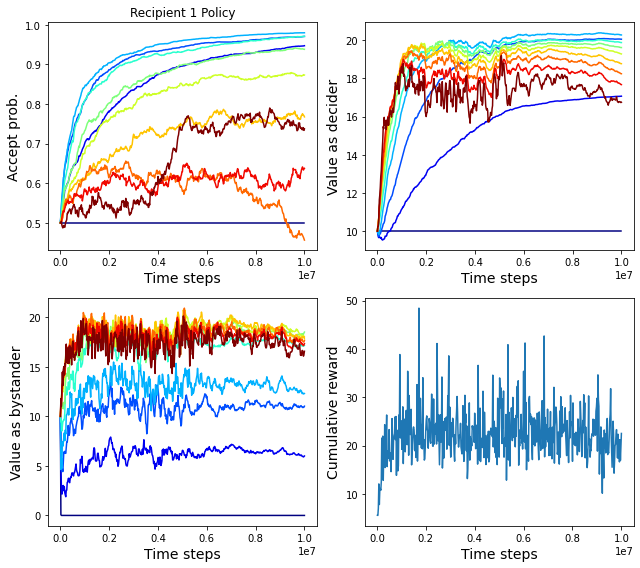

In [11]:
pol_par, h = ut.read_2d_traj(data_dir+'/policy'+str(player)+'_traj.txt')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(9,8))
colors = plt.cm.jet(np.linspace(0,1,int(env_params['max_k'])+1))
xs = np.linspace(0, alg_params['n_steps'], int(alg_params['traj_points']+1))

ax1.set_xlabel('Time steps', fontsize=14)
if player == 0:
    pol_str = 'Gathering'
    pl_str = 'Forager'
else:
    pol_str = 'Accept'
    pl_str = 'Recipient {}'.format(player)
ax1.set_ylabel(pol_str + ' prob.', fontsize=14)
ax1.set_title(pl_str + ' Policy')
for k in range(0,int(env_params['max_k'])+1):
    ax1.plot(xs, [p[k][0] for p in pol_par], c=colors[k], label="k={}".format(k))
#ax1.legend()

ax2.set_xlabel('Time steps', fontsize=14)
ax2.set_ylabel('Value as decider', fontsize=14)
for k in range(0,int(env_params['max_k'])+1):
    ax2.plot(xs, np.array(v_traj)[:,player,k], color=colors[k])

ax3.set_xlabel('Time steps', fontsize=14)
ax3.set_ylabel('Value as bystander', fontsize=14)
for k in range(0,int(env_params['max_k'])+1):
    ax3.plot(xs, np.array(v_traj)[:,player,k+int(env_params['max_k'])+1], c=colors[k])

ax4.set_xlabel('Time steps', fontsize=14)
ax4.set_ylabel('Cumulative reward', fontsize=14)
wind_size=500
#times, new_traj = ut.smooth_traj(np.array(info_traj, dtype=float)[:,player+int(env_params['n_recipients'])+4], wind_size)
#ax4.set_title('Smoothed with window of {} episodes'.format(wind_size))
ax4.plot(xs[1:], np.array(info_traj,dtype=float)[1:,player+int(env_params['n_recipients'])+4])

plt.tight_layout()
#plt.savefig('plots/'+system_name+'/'+run_name+'/learning_'+str(player)+'.png', dpi=200)

### Time scales

In [108]:
env_params['stop_at_first_death']=False

In [109]:
info_traj = np.array(info_traj, dtype=float)
f_gamma = np.array(info_traj)[1:,int(env_params['n_recipients'])+3]
tot_freq = np.array(info_traj)[1:,0]+np.array(info_traj)[1:,1]+np.array(info_traj)[1:,2]+f_gamma
if env_params['stop_at_first_death']: 
    tot_freq += np.array(info_traj)[1:,3]
else:
    tot_freq += np.array(info_traj)[1:,int(env_params['n_recipients'])+2]

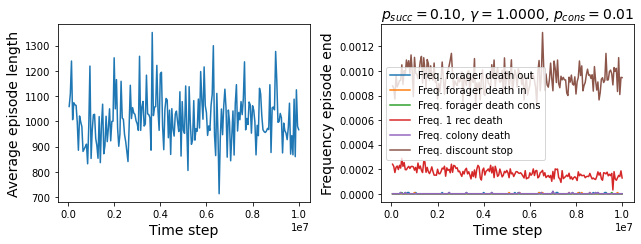

In [171]:
xs = np.linspace(0, alg_params['n_steps'], int(alg_params['traj_points']+1))[1:]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,3.5))

av_length = 1/tot_freq
ax1.set_xlabel('Time step', fontsize=14)
ax1.set_ylabel('Average episode length', fontsize=14)
ax1.plot(xs, av_length)

ax2.set_xlabel('Time step', fontsize=14)
ax2.set_ylabel('Frequency episode end', fontsize=14)
ax2.set_title(r"$p_{succ}=%3.2f$, $\gamma=%5.4f$, $p_{cons}=%3.2f$" %(env_params['p_succ'], alg_params['gamma'], env_params['p_consume']), fontsize=14)
ax2.plot(xs, np.array(info_traj)[1:,0], label='Freq. forager death out')
ax2.plot(xs, np.array(info_traj)[1:,1], label='Freq. forager death in')
ax2.plot(xs, np.array(info_traj)[1:,2], label='Freq. forager death cons')
ax2.plot(xs, np.array(info_traj)[1:,3], label='Freq. 1 rec death')
ax2.plot(xs, np.array(info_traj)[1:,int(env_params['n_recipients'])+1], label='Freq. colony death')
ax2.plot(xs, f_gamma, label='Freq. discount stop')
ax2.legend()


plt.tight_layout()
plt.savefig('plots/'+system_name+'/'+run_name+'/times.png', dpi=200)

In [170]:
ev_info, ev_info_h = ut.read_traj(data_dir+'/ev_info.txt')
ev_states, ev_states_h = ut.read_traj(data_dir+'/ev_states.txt')
print(ev_info_h, ev_states_h)

['aggr_state0', 'aggr_state1', 'aggr_state2', 'aggr_state3', 'aggr_state4', 'aggr_state5', 'aggr_state6', 'aggr_state7', 'aggr_state8', 'aggr_state9', 'aggr_state10', 'action0', 'action1', 'action2', 'action3', 'action4', 'action5', 'action6', 'action7', 'action8', 'action9', 'action10', 'aggr_new_state0', 'aggr_new_state1', 'aggr_new_state2', 'aggr_new_state3', 'aggr_new_state4', 'aggr_new_state5', 'aggr_new_state6', 'aggr_new_state7', 'aggr_new_state8', 'aggr_new_state9', 'aggr_new_state10', 'reward0', 'reward1', 'reward2', 'reward3', 'reward4', 'reward5', 'reward6', 'reward7', 'reward8', 'reward9', 'reward10', 'done', 'step'] ['decider', 'forager_load', 'rec1_load', 'rec2_load', 'rec3_load', 'rec4_load', 'rec5_load', 'rec6_load', 'rec7_load', 'rec8_load', 'rec9_load', 'rec10_load']


In [734]:
def get_food_from_aggr(as1, as2):
    f1, f2 = as1, as2
    decider = -1
    if as1 > env_params['max_k']:
        f1 = as1 - env_params['max_k'] - 1 
        decider = 1
    if as2 > env_params['max_k']:
        f2 = as2 - env_params['max_k'] - 1 
        decider = 0
    return f1, f2, decider

def get_action(decider, action0, action1):
    """Return:
        0: gathering
        1: sharing
        2: accept
        3: reject
    """
    if decider == 0 and action0 == 0:
        return 0
    elif decider == 0 and action0 == 1:
        return 1
    elif decider == 1 and action1 == 0:
        return 2
    elif decider == 1 and action1 == 1:
        return 3
    else:
        print('Action error')
        return -1
    
def get_done_type(f1, f2, dec):
    """Return:
        0: forager out
        1: forager in
        2: recipient
        3: gamma
    """
    if f1==0 and dec==0:
        return 0
    elif f1==0 and dec==1:
        return 1
    elif f2==0:
        return 2
    else:
        return 3

In [735]:
# Finiding the first done
done_ind = 0
while True:
    if ev_info[done_ind][-2] == 1:
        done_ind += 1
        break
    done_ind += 1
    
food_trajs = []
returns = []
times = []
end_reached = False
while not end_reached:
    food_traj = []
    r, t = 0, 0
    while True:
        
        done_ind += 1
        if done_ind >= len(ev_info):
            end_reached = True
            break
            
        f1, f2, dec = get_food_from_aggr(ev_info[done_ind][0], ev_info[done_ind][1])
        a = get_action(dec, ev_info[done_ind][2], ev_info[done_ind][3])
        if a == 2:
            r+=1
        food_traj.append([f1, f2, a])
        if ev_info[done_ind][-2] == 1:
            f1, f2, _ = get_food_from_aggr(ev_info[done_ind][4], ev_info[done_ind][5])
            end = get_done_type(f1, f2, dec)
            food_traj.append([f1, f2, end])
            returns.append(r)
            times.append(ev_info[done_ind][-1])
            break
            
    food_trajs.append(np.array(food_traj))
    
food_trajs = food_trajs[:-1]

Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error
Action error

IndexError: list index out of range

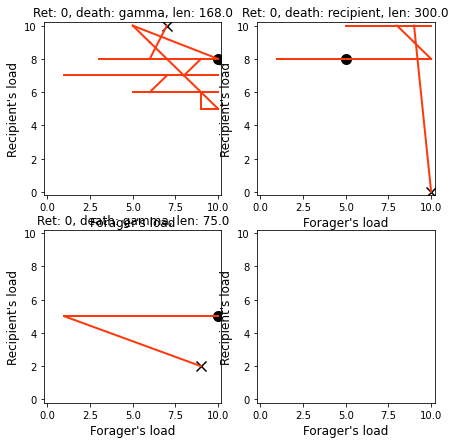

In [736]:
indexes = [0,1,2,3]
action_colors = ['#0b80ff', '#efdc01', '#5fd809', '#ff380b']
end_type = ["forager out","forager in","recipient","gamma"]

n_rows =int(np.floor(len(indexes)/2)) 
fig, axs = plt.subplots(n_rows,2,figsize=(7, 3.5*n_rows))

for index in indexes:
    row = int(np.floor(index/2))
    col = index%2
    axs[row][col].set_xlabel("Forager's load", fontsize=12)
    axs[row][col].set_ylabel("Recipient's load", fontsize=12)
    axs[row][col].set_xlim(-0.2,10.2)
    axs[row][col].set_ylim(-0.2,10.2)
    axs[row][col].set_title("Ret: "+str(returns[index])+", death: " + end_type[int(food_trajs[index][-1,2])] + ", len: " + str(times[index]), fontsize=12)
    
    axs[row][col].scatter(food_trajs[index][0,0], food_trajs[index][0,1], s=100, c='black')
    axs[row][col].scatter(food_trajs[index][-1,0], food_trajs[index][-1,1], s=100, marker='x', c='black')
    
    for i in range(1, len(food_trajs[index])):
        axs[row][col].plot(food_trajs[index][i-1:i+1,0], 
                 food_trajs[index][i-1:i+1,1], 
                 c=action_colors[int(food_trajs[index][i-1,2])], lw=2)

axs[0][0].plot([0,0],[0,0], c=action_colors[0], lw=2, label='Foraging')
axs[0][0].plot([0,0],[0,0], c=action_colors[1], lw=2, label='Sharing')
axs[0][0].plot([0,0],[0,0], c=action_colors[2], lw=2, label='Accept')
axs[0][0].plot([0,0],[0,0], c=action_colors[3], lw=2, label='Reject')
axs[0][0].legend(fontsize=12)

plt.tight_layout()
plt.savefig('plots/'+system_name+'/'+run_name+'/trajectories.png', dpi=200)

In [ ]:
action_colors[int(food_trajs[index][i,2])]

In [185]:
# Analysis of food distribution.
import numpy as np
data = np.loadtxt(data_dir+'/ev_info.txt', skiprows=1)

In [186]:
N = 11
Mmax = 10
histo = np.zeros(Mmax+1)

count_ep = 0

final_colony = np.array([])
final_forager = np.array([])

while np.argmax(data[:,4*N]==1) :
    count_ep += 1
    split_index = np.argmax(data[:,4*N]==1)
    ep, data = np.array_split(data, [split_index+1])
    agent = np.argmax( ep[:,:N]<N)
    final_colony = np.append(final_colony, ep[-1,1:N]%(Mmax+1))
    final_forager = np.append(final_forager, ep[-1,0]%(Mmax+1))
    final_food_colony = np.sum(ep[-1,1:N]%11)
    final_food_forager = ep[-1,0]%11
    #print(final_food_colony, final_food_forager)

food_dist_r, _ = np.histogram(final_colony,  bins=(Mmax+1), range=(-0.5, (Mmax+0.5)))
food_dist_f, _ = np.histogram(final_forager, bins=(Mmax+1), range=(-0.5, (Mmax+0.5)))